# **Proyek Klasifikasi Gambar: Blood Cells Dataset**
- **Nama:** Muhammad Ilham Ramadhan
- **Email:** ilhammuhramadhan@gmail.com
- **ID Dicoding:** MC004D5Y2072

## **Import Packages/Library**

In [ ]:
# import library untuk kebutuhan pengolahan data dan permodelan
import kagglehub
import os
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install split-folders
import splitfolders
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
!pip install tensorflowjs


## **Data Preparation**

### Data Loading

In [ ]:
# mengimport dataset dari kaggle
path = kagglehub.dataset_download("unclesamulus/blood-cells-image-dataset")
print(f'Folder : {os.listdir(path)}')

100%|██████████| 268M/268M [00:02<00:00, 129MB/s]

Extracting files...


Folder : ['bloodcells_dataset']


In [ ]:
# menyimpan data
data_dir = os.path.join(path, 'bloodcells_dataset')

In [ ]:
# menampilkan informasi kelas dari  data
class_names = sorted(os.listdir(data_dir))
print("Class Names :", class_names)

Class Names : ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


In [ ]:
# mengecek resolusi dan jumlah gambar pada tiap kelas
def images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"\nTotal Images of {subdir} : {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"Size : {size}")

    print(f"\nTotal Images : {total_images}")

In [ ]:
# memunculkan resolusi gambar dan jumlah gambar pada tiap kelas
images_resolution(data_dir)


Total Images of platelet : 2348
Size : (360, 363)

Total Images of basophil : 1218
Size : (366, 369)
Size : (360, 363)

Total Images of erythroblast : 1551
Size : (366, 369)
Size : (360, 360)
Size : (362, 360)
Size : (360, 363)

Total Images of neutrophil : 3329
Size : (366, 369)
Size : (360, 360)
Size : (362, 360)
Size : (360, 363)

Total Images of eosinophil : 3117
Size : (366, 369)
Size : (360, 360)
Size : (362, 360)
Size : (360, 363)

Total Images of lymphocyte : 1214
Size : (366, 369)
Size : (360, 360)
Size : (362, 360)
Size : (360, 363)

Total Images of ig : 2895
Size : (359, 360)
Size : (360, 361)
Size : (362, 360)
Size : (360, 363)
Size : (360, 360)
Size : (361, 360)
Size : (366, 369)

Total Images of monocyte : 1420
Size : (359, 360)
Size : (360, 361)
Size : (362, 360)
Size : (360, 363)
Size : (360, 360)
Size : (361, 360)
Size : (366, 369)

Total Images : 17092


In [ ]:
# mengelompokkan data menjadi kolom image dan label
images = []
labels = []

for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    if os.path.isdir(folder_path):
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            images.append(image_path)
            labels.append(folder_name)

In [ ]:
# menyimpan data ke dalam dataframe
df = pd.DataFrame({'Image': images, 'Labels': labels})
df.head()

,Image,Labels
0,/root/.cache/kagglehub/datasets/unclesamulus/b...,platelet
1,/root/.cache/kagglehub/datasets/unclesamulus/b...,platelet
2,/root/.cache/kagglehub/datasets/unclesamulus/b...,platelet
3,/root/.cache/kagglehub/datasets/unclesamulus/b...,platelet
4,/root/.cache/kagglehub/datasets/unclesamulus/b...,platelet


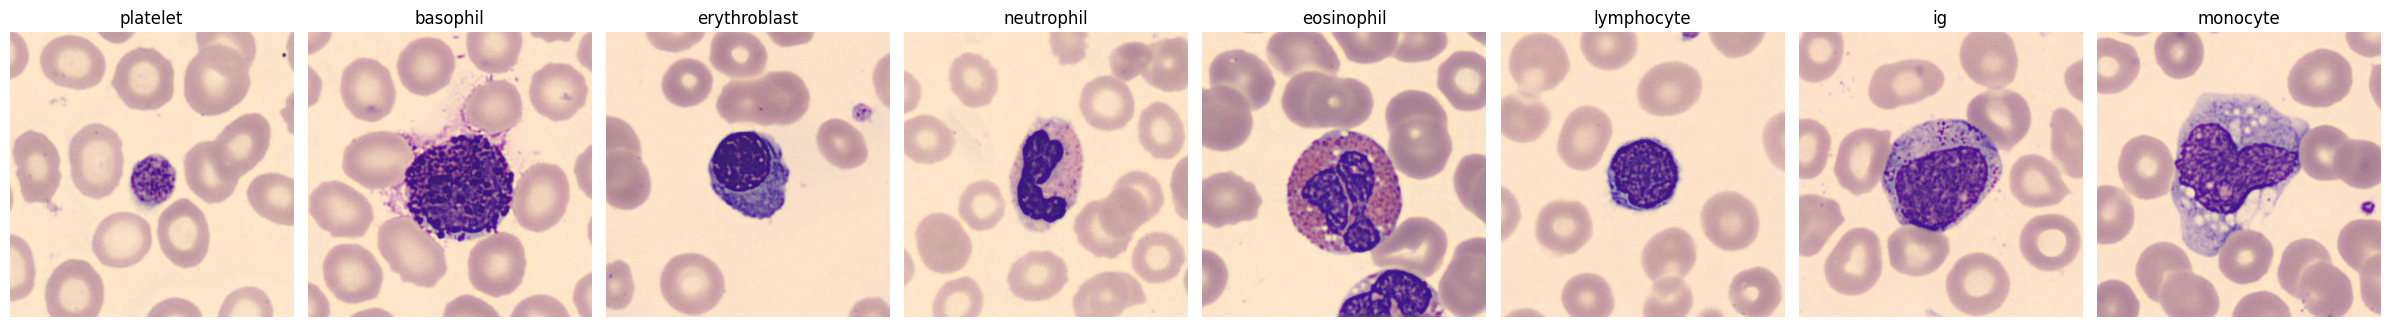

In [ ]:
# memunculkan gambar dari setiap kelas
label_names = df['Labels'].unique()
plt.figure(figsize=(24,6))

for idx, label_name in enumerate(label_names):
    img_path = df[df['Labels'] == label_name].iloc[0]['Image']
    img = Image.open(img_path)
    plt.subplot(1, len(label_names), idx + 1)
    plt.imshow(img)
    plt.title(label_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

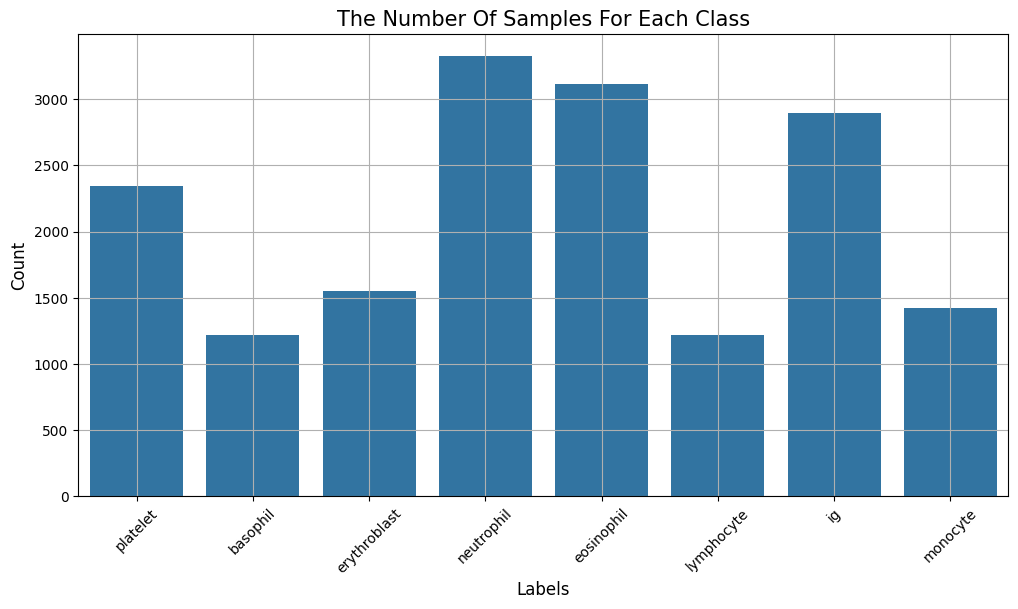

In [ ]:
# menampilkan distribusi data pada tiap kelas
plt.figure(figsize=(12,6))
ax = sns.countplot(x=df.Labels)
ax.set_xlabel("Labels",fontsize=12)
ax.set_ylabel("Count",fontsize=12)
plt.title('The Number Of Samples For Each Class',fontsize=15)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Data Preprocessing

#### Split Dataset

In [ ]:
# membagi data menjadi data latih, validasi, dan uji
train_df, val_test_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 42)
val_df, test_df = train_test_split(val_test_df,  train_size= 0.6, shuffle= True, random_state= 42)

In [ ]:
# menampilkan jumlah data latih, validasi, dan uji
print('Data Training Shape    : ', len(train_df))
print('Data Validation Shape  : ', len(val_df))
print('Data Testing Shape     : ', len(test_df))

Data Training Shape    :  13673
Data Validation Shape  :  2051
Data Testing Shape     :  1368


#### Data Augmentation

In [ ]:
# menentukan nilai dari parameter
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
# mengatur generator untuk data latih, validasi, dan uji
datagen = ImageDataGenerator(rescale=1.0/255)

train_datagen = datagen.flow_from_dataframe(
    train_df,
    x_col='Image',
    y_col='Labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_datagen = datagen.flow_from_dataframe(
    val_df,
    x_col='Image',
    y_col='Labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = datagen.flow_from_dataframe(
    test_df,
    x_col='Image',
    y_col='Labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 13673 validated image filenames belonging to 8 classes.
Found 2051 validated image filenames belonging to 8 classes.
Found 1368 validated image filenames belonging to 8 classes.


In [ ]:
# melakukan augmentasi data
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
    ])

## **Modelling**

In [ ]:
# melakukan permodelan CNN
model = Sequential([
    data_augmentation,
    Conv2D(filters=8, kernel_size=(5,5),
                  padding="same", activation="relu",
                  kernel_initializer="he_normal"),
    MaxPooling2D(),
    Conv2D(filters=16, kernel_size=(3,3),
                  padding="same", activation="relu",
                  kernel_initializer="he_normal"),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=(3,3),
                  padding="same", activation="relu",
                  kernel_initializer="he_normal"),
    MaxPooling2D(),
    Flatten(),
    Dense(8, activation="softmax")
    ])

In [ ]:
# mengcompile model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# menetapkan callback untuk menghentikan pelatihan
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

]

In [ ]:
# melatih model
history = model.fit(
    train_datagen,
    epochs = 20,
    validation_data = val_datagen,
    callbacks = callbacks
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


428/428 ━━━━━━━━━━━━━━━━━━━━ 43s 85ms/step - accuracy: 0.5517 - loss: 1.2425 - val_accuracy: 0.8250 - val_loss: 0.5298
Epoch 2/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 35s 81ms/step - accuracy: 0.8605 - loss: 0.4158 - val_accuracy: 0.8981 - val_loss: 0.3004
Epoch 3/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 33s 76ms/step - accuracy: 0.8987 - loss: 0.3006 - val_accuracy: 0.8825 - val_loss: 0.3713
Epoch 4/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 36s 83ms/step - accuracy: 0.9042 - loss: 0.2893 - val_accuracy: 0.8937 - val_loss: 0.3040
Epoch 5/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 40s 94ms/step - accuracy: 0.9271 - loss: 0.2156 - val_accuracy: 0.9322 - val_loss: 0.2094
Epoch 6/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 35s 82ms/step - accuracy: 0.9226 - loss: 0.2169 - val_accuracy: 0.8835 - val_loss: 0.3364
Epoch 7/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.9295 - loss: 0.2132 - val_accuracy: 0.9196 - val_loss: 0.2405
Epoch 8/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 33s 77ms/step - accuracy: 0.9382 - loss: 0.1838 - val_accurac

## **Evaluasi dan Visualisasi**

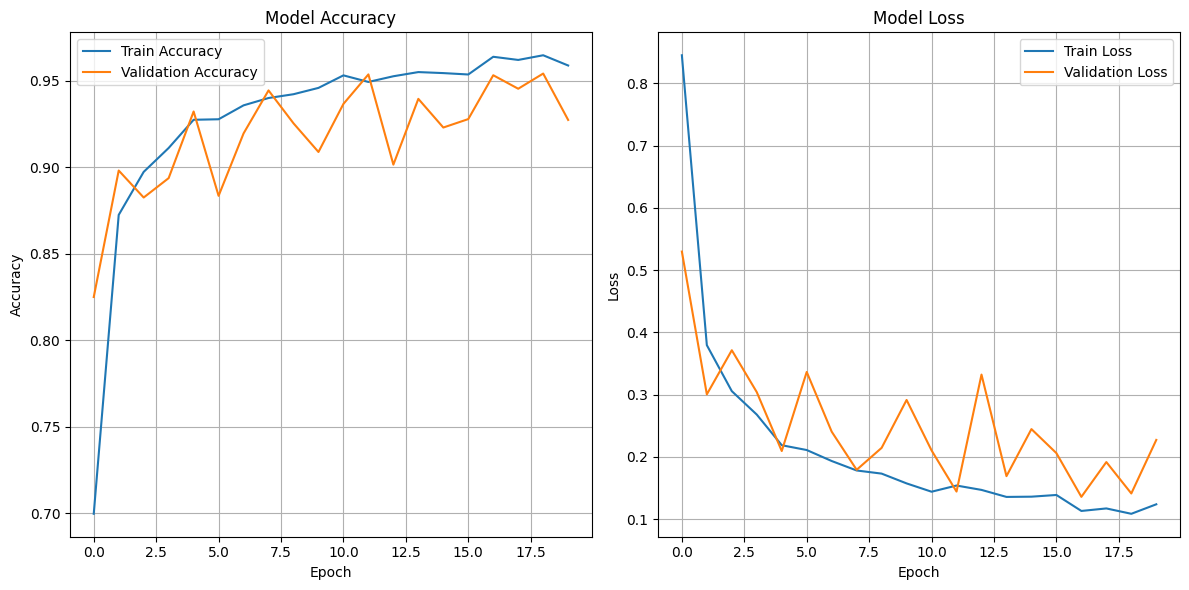

In [ ]:
# memvisualisasikan hasil pelatihan model
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Model Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# memunculkan hasil penerapan model pada data uji
test_loss, test_acc = model.evaluate(test_datagen, verbose=0)

print(f"Test Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Loss     : 0.1061
Test Accuracy : 0.9642




              precision    recall  f1-score   support

    basophil     0.8909    0.9800    0.9333       100
  eosinophil     1.0000    0.9887    0.9943       266
erythroblast     0.9556    0.9699    0.9627       133
          ig     0.9466    0.8904    0.9176       219
  lymphocyte     0.9800    0.9800    0.9800       100
    monocyte     0.9674    0.9175    0.9418        97
  neutrophil     0.9474    0.9783    0.9626       276
    platelet     1.0000    1.0000    1.0000       177

    accuracy                         0.9642      1368
   macro avg     0.9610    0.9631    0.9615      1368
weighted avg     0.9648    0.9642    0.9641      1368



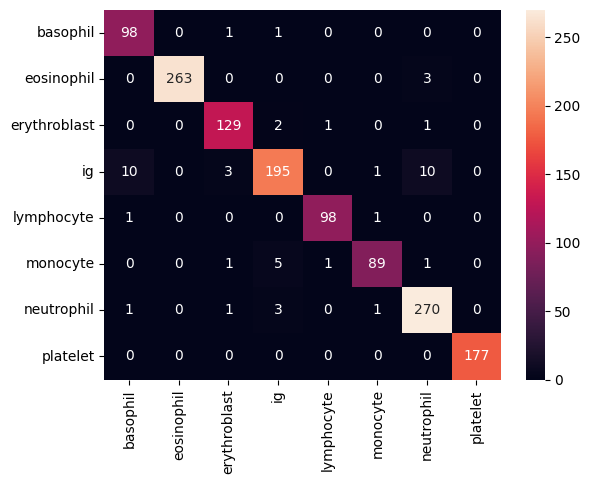

In [ ]:
# memunculkan classification report dan confusion matrix
test_datagen.reset()

preds = model.predict(test_datagen, verbose=0)
preds = np.argmax(preds, axis=1)

cm = pd.DataFrame(data=confusion_matrix(test_datagen.classes, preds),
                  index=class_names,
                  columns=class_names)

sns.heatmap(cm, annot=True, fmt="d")

print("\n")
print(classification_report(y_true=test_datagen.classes, y_pred=preds, target_names=class_names, digits=4))


## **Konversi Model**

In [ ]:
# menyimpan model
os.makedirs('Submission/saved_model', exist_ok=True)
model.export('Submission/saved_model')

Saved artifact at 'Submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_13')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  135046491844304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135046491845456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135046491841616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135046491845648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135046491843152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135046491844496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135046491844688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135046491846608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135046491842000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135046567665808: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
# menyimpan model ke dalam format TensorFlow.js
os.makedirs('Submission/tfjs_model', exist_ok=True)

model.save('model.h5')
!tensorflowjs_converter --input_format=keras model.h5 Submission/tfjs_model
os.remove('model.h5')

2025-04-26 20:03:42.682728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745697822.702909    9780 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745697822.709051    9780 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
# menyimpan model ke dalam format TFLite
os.makedirs('Submission/tflite', exist_ok=True)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('Submission/tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

with open('Submission/tflite/labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

Saved artifact at '/tmp/tmpwd3t7ga0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_13')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  135046491841616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135046491845648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135046491843152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135046491844496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135046491844688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135046491846608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135046491842000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135046567665808: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
# mengeskpor model ke dalam Google Drive
from google.colab import drive
drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/Submission'
!cp -r /content/Submission/ {base_dir}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Inference (Optional)**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


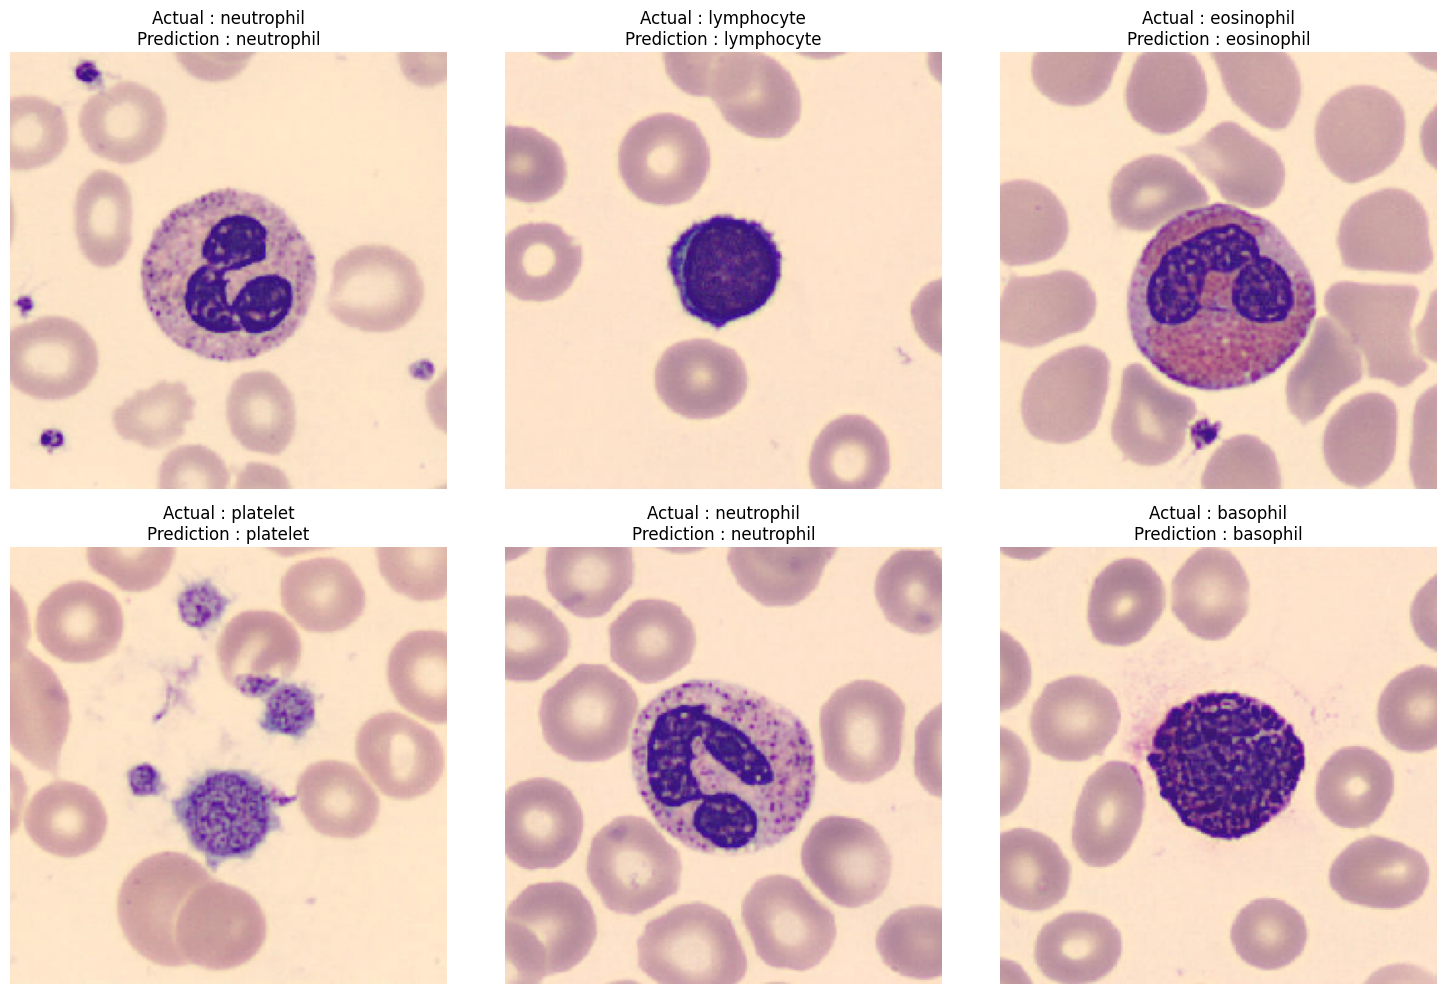

In [ ]:
# menggunakan model untuk memprediksi data uji
val_images, val_labels = next(val_datagen)

pred_labels = model.predict(val_images)
pred_labels = np.argmax(pred_labels, axis=1)
true_labels = np.argmax(val_labels, axis=1)

class_indices = val_datagen.class_indices
class_names = {v: k for k, v in class_indices.items()}

def images_prediction(images, true_labels, pred_labels, class_names, num_images=6):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        true_label = class_names[int(true_labels[i])]
        pred_label = class_names[int(pred_labels[i])]
        plt.title(f"Actual : {true_label}\nPrediction : {pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

images_prediction(val_images, true_labels, pred_labels, class_names, num_images=6)